# Notes on How to run caffe

1. examples from caffe python code in the `examples` folder from [github](https://github.com/BVLC/caffe)
2. installation guide please see [installation.txt](installation.txt) 
3. since caffe is written in c++, the doc of its python inferface is not always available

## Summary
- use `caffe.Net` to load net structure (deploy.prototxt) and model weights (.caffemodel). Then you can play with it via `net.blobs` and `net.params` and `net.forward` and `net.backward`
- use `caffe.NetSpec` and `caffe.layers` with `caffe.params` to construct train.prototxt and test.prototxt. You still need to manually set `solver.txt` to train a model. Use `caffe.get_solver` and `solver.solve()` to train the model. You can load the trained model via `caffe.net` back, but you need a `deoploy.txt`
- use `caff.SGDSolver` to read the solver.prototxt and `solver.net.copy_from` to read the weight (.caffemodel) - it is suitable for fine-tune an existing model, and you don't need a deploy.prototxt yet

In summay
- you need a `.caffemodel` weight file and `deploy.prototxt` to use/inspect a model
- you can also use `solver.prototxt` and `.caffemodel` to load a model back to its training pahse
- you need a `solver.prototxt` (and thus `train.prototxt` and `test.prototxt` dependency) to train a model 
- you need both `solver.prototxt` and `.caffemodel` to fine-tune an existing model

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import caffe

## Basic Usage

In [3]:
## set your device - you will remember this when you have a gpu
caffe.set_mode_cpu()
CAFFE_MODELS = "/home/dola/opt/caffe/models/"

In [4]:
## caffe.Net is the main entrance to everything
## three parameter in the construtor
## 1. path to the model's prototcal - use deploy for feature extraction / prediction
## 2. binary weight file - .caffemodel file 
## 3. caffe.TRAIN or caffe.TEST
net = caffe.Net(CAFFE_MODELS + "bvlc_reference_caffenet/deploy.prototxt", 
               CAFFE_MODELS + "bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel", 
               caffe.TEST)

In [5]:
net.blobs

OrderedDict([('data', <caffe._caffe.Blob object at 0x7f1cbe08ef50>), ('conv1', <caffe._caffe.Blob object at 0x7f1cbe08eed8>), ('pool1', <caffe._caffe.Blob object at 0x7f1cbe08ee60>), ('norm1', <caffe._caffe.Blob object at 0x7f1cbe08ed70>), ('conv2', <caffe._caffe.Blob object at 0x7f1cbe08ecf8>), ('pool2', <caffe._caffe.Blob object at 0x7f1cbe08ec80>), ('norm2', <caffe._caffe.Blob object at 0x7f1cbe08ec08>), ('conv3', <caffe._caffe.Blob object at 0x7f1cbe08eb90>), ('conv4', <caffe._caffe.Blob object at 0x7f1cbe08eb18>), ('conv5', <caffe._caffe.Blob object at 0x7f1cbe08eaa0>), ('pool5', <caffe._caffe.Blob object at 0x7f1cbe08ea28>), ('fc6', <caffe._caffe.Blob object at 0x7f1cbe08e9b0>), ('fc7', <caffe._caffe.Blob object at 0x7f1cbe08e938>), ('fc8', <caffe._caffe.Blob object at 0x7f1cbe08e8c0>), ('prob', <caffe._caffe.Blob object at 0x7f1cbe08e848>)])

In [6]:
net.params

OrderedDict([('conv1', <caffe._caffe.BlobVec object at 0x7f1cbe290210>), ('conv2', <caffe._caffe.BlobVec object at 0x7f1cbe2902f0>), ('conv3', <caffe._caffe.BlobVec object at 0x7f1cbe2903d0>), ('conv4', <caffe._caffe.BlobVec object at 0x7f1cbe290440>), ('conv5', <caffe._caffe.BlobVec object at 0x7f1cbe2904b0>), ('fc6', <caffe._caffe.BlobVec object at 0x7f1cbe290520>), ('fc7', <caffe._caffe.BlobVec object at 0x7f1cbe290590>), ('fc8', <caffe._caffe.BlobVec object at 0x7f1cbe290600>)])

In [7]:
net.inputs, net.outputs

(['data'], ['prob'])

In [8]:
## caffe transformer is the way of converting real world pictures into caffe blobs
## The transformer records a set of processing operations for different type of blobs
## The general usage of transformer are 
## (1) construct a transformer with a dict of {dataName: dataShape}, 
## usually the dataName corresponds to one of blobs for caffe net
## (2) for each dataName, set different operations e.g. `set_transpose`
## `set_mean`, `set_raw_scale` and `set_channel_swap`
## (3) call `preprocess(dataName, realData)` and set this to caffe net's blob to finish
## initialization of caffe inputs (and thus call forward later)
## (4) call `deprocess` to revert the `preprocess`

## set a transformer from real image to caffe net's data blob
## the shape is data_blob's raw data's shape - e.g.(10, 3, 227, 227) - 10 images, 3 colors
## the shape of blob can be recast to what you want, e.g., `net.blobs['data'].reshape(50,3,227,227)`
## which specify we need the mini-batch to be 50 instead of 10
net.blobs['data'].reshape(50,3,227,227)
print net.blobs['data'].data.shape
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) ## first dim ignored
transformer.set_transpose('data', (2, 0, 1))
transformer.set_channel_swap('data', (2, 1, 0)) # rgb -> bgr
transformer.set_raw_scale('data', 255)
imagemean = np.load("/home/dola/opt/caffe/python/caffe/imagenet/ilsvrc_2012_mean.npy")
print imagemean.shape
transformer.set_mean('data',imagemean.mean(1).mean(1))

(50, 3, 227, 227)
(3, 256, 256)


### Let's take a closer look at what happens in the above code
1. `caffe.io.load_image('/home/dola/opt/caffe/examples/images/cat.jpg')` read an normal image and its shape is (360, 480, 3) with RGB channels
2. what `transformer.preprocess` does are the following
    - resize the image by interpolation/upsampling/downsampling to make sure the number of raw pixels of resized images match the total number of blob, i.e. ,360x480x3 -> 3x277x277
    - transpose the image as real-world image are encoded by (W, H, C) whereas blob asks for (B, C, W, H), i.e. (3, 277, 277). B is batch size, which is kinda free.
    - swap the color channels in C as caffe assumes BGR order whereas most of realworld images are RGB
    - scale the pixels (e.g., from [0, 255] to [0, 1])
    - center the pixels by substracting the mean (learnt from previous model) 
    - scale the input vectors again - it is most of time optional unless the caffe model needs to map the data again

In [9]:
## now you can set the image as the data input for caffe model
## [...] does the trick because `net.blobs['data'].data` has the shape (50, 3, 227, 227)
## where as the preprocessed data has the shape of (3, 227, 227)
image = caffe.io.load_image('/home/dola/opt/caffe/examples/images/cat.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

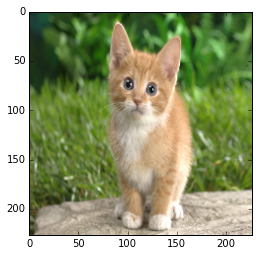

In [10]:
## now you can see the preprocssed image by inverting it
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

In [11]:
## forward the calculation - the same as net.blobs['prob'].data
out = net.forward()
print out['prob'].shape
print out['prob'].argmax()

(50, 1000)
281


In [12]:
imagenet_labels_filename = '/home/dola/opt/caffe/data/ilsvrc12/synset_words.txt'
labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
print labels.shape
labels[[281]]

(1000,)


array(['n02123045 tabby, tabby cat'], 
      dtype='|S131')

## Visualize the inside of network

How to interpret the blobs and params of learned net

- conceptually params can be viewed as lists of blobs. param[0] are
weights and param[1] are biases, but for certain layers such as 'conv1' weights and biases are the same

### parameter view

In [13]:
w, b = net.params['conv1'][0], net.params['conv1'][0]
print w.data.shape, b.data.shape
print np.all(w.data == b.data)

(96, 3, 11, 11) (96, 3, 11, 11)
True


In [14]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    
def vis_square(data):
    data -= data.min()
    data /= data.max()
    n = int(np.ceil(np.sqrt(data.shape[0])))
    fig, axes = plt.subplots(n, n, figsize = (10, 10))
    axes = axes.ravel()
    fig.subplots_adjust(wspace = 0, hspace = 0)
    for i in xrange(len(axes)):
        if i < data.shape[0]:
            axes[i].imshow(data[i,])
        axes[i].set_axis_off()

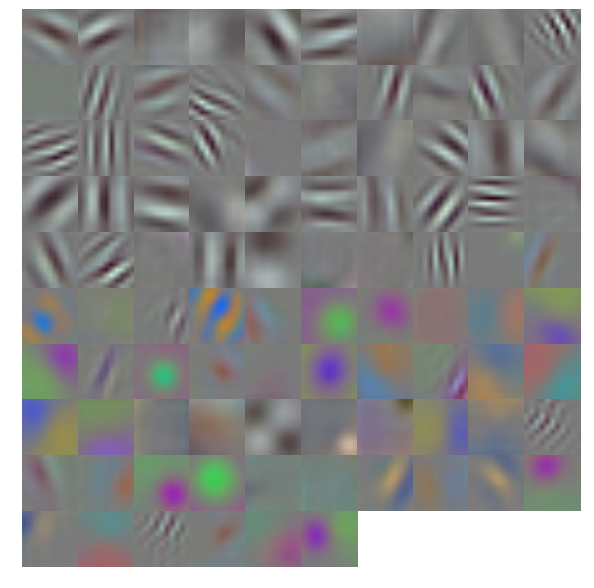

In [15]:
plt.figure(figsize = (6, 6))
vis_square(w.data.transpose(0, 2, 3, 1))

### input feature view

(50, 96, 55, 55)


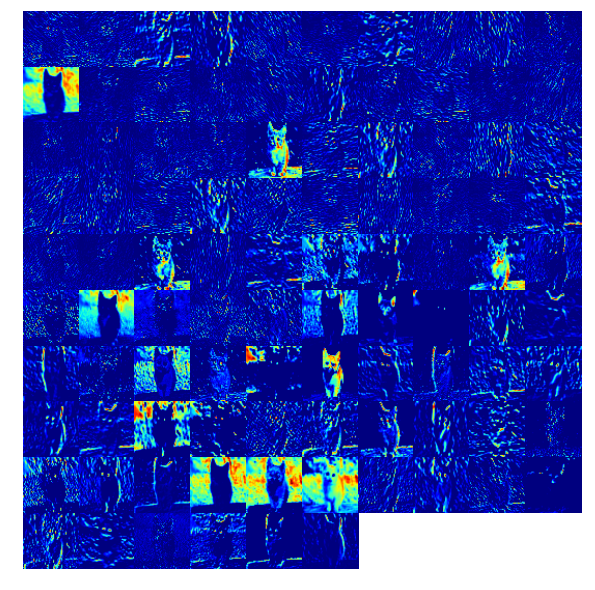

In [16]:
print net.blobs['conv1'].data.shape
vis_square(net.blobs['conv1'].data[0])

## Training of Caffe
- Caffe model can be constructed and trained directly within python, see [tutorial](https://github.com/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb) here for details.

## Training Caffe for other Data than images
- Like in the example above, it uses caffe.layers to create layers and caffe.params to specify the type of parameters in each layer

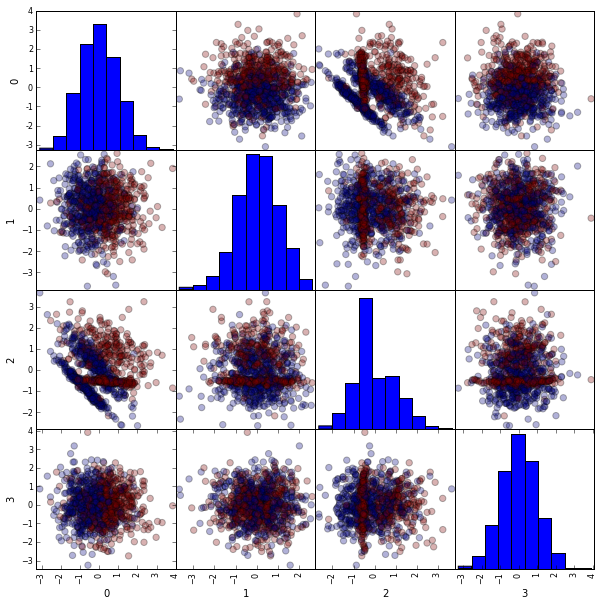

In [ ]:
## synthesize 10,000 4-vectors for binary classification with 2 informative and 2 noise features
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
import pandas as pd

X, y = make_classification(n_samples=10000, n_features=4, 
                           n_redundant=0, n_informative=2, 
                           n_clusters_per_class=2, hypercube=False, 
                           random_state=314)
X = X.astype(np.float32)
y = y.astype(np.int8)
X, Xt, y, yt = train_test_split(X, y, test_size = 0.2)
## visualize the data
ind = np.random.permutation(X.shape[0])[:1000]
df = pd.DataFrame(X[ind])
_ = pd.scatter_matrix(df, figsize = (10, 10), marker = 'o', s = 40, alpha = 0.3, c=y[ind])

In [ ]:
## benchmark with logistic regression learnt by SGD
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
model = SGDClassifier(loss = 'log', n_iter = 1000)
searcher = GridSearchCV(model, {'alpha': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
                               , 'penalty': ['l1', 'l2']}, 
                        cv = 5, n_jobs = -1)
searcher.fit(X, y)
model = searcher.best_estimator_
print searcher.best_params_
model.score(Xt, yt)

***Everything in HDF5 must be float32 for Caffe to read***

In [ ]:
## write the data to hdf5, which can be utilized by caffe
## caffe takes a file with each line specifying an hdf file
import h5py
with h5py.File("../data/tmp/train.h5", "w") as f:
    f['data'] = X
    f['label'] = y.astype(np.float32)
with h5py.File("../data/tmp/test.h5", "w") as f:
    f['data'] = Xt
    f['label'] = yt.astype(np.float32)
open("../data/tmp/train.txt", "w").write("\n".join(["train.h5"] * 2))
open("../data/tmp/test.txt", "w").write("test.h5")

In [ ]:
## construct caffe layers and specify layer parameters
## but the pydoc to those methods are not directly exposed,
## I find it more convienent to write the prototxt files directly, which is equivallently 
## the same thing
from caffe import layers as L
from caffe import params as P
def logreg(hdf5, batch_size):
    # logistic regression: data, matrix multiplication, and 2-class softmax loss
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    n.ip1 = L.InnerProduct(n.data, num_output=2, weight_filler=dict(type='xavier'))
    n.accuracy = L.Accuracy(n.ip1, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip1, n.label)
    return n.to_proto()
    
with open('../data/tmp/logreg_auto_train.prototxt', 'w') as f:
    f.write(str(logreg('../data/tmp/train.txt', 10)))
    
with open('../data/tmp/logreg_auto_test.prototxt', 'w') as f:
    f.write(str(logreg('../data/tmp/test.txt', 10)))
    
def nonlinear_net(hdf5, batch_size):
    # one small nonlinearity, one leap for model kind
    n = caffe.NetSpec()
    n.data, n.label = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=2)
    # define a hidden layer of dimension 40
    n.ip1 = L.InnerProduct(n.data, num_output=40, weight_filler=dict(type='xavier'))
    # transform the output through the ReLU (rectified linear) non-linearity
    n.relu1 = L.ReLU(n.ip1, in_place=True)
    # score the (now non-linear) features
    n.ip2 = L.InnerProduct(n.ip1, num_output=2, weight_filler=dict(type='xavier'))
    # same accuracy and loss as before
    n.accuracy = L.Accuracy(n.ip2, n.label)
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    
with open('../data/tmp/nonlinear_auto_train.prototxt', 'w') as f:
    f.write(str(nonlinear_net('train.txt', 10)))
    
with open('../data/tmp/nonlinear_auto_test.prototxt', 'w') as f:
    f.write(str(nonlinear_net('test.txt', 10)))

In [ ]:
open("../data/tmp/solver.prototxt", "w").write(r"""train_net: "nonlinear_auto_train.prototxt"
test_net: "nonlinear_auto_test.prototxt"
test_iter: 250
test_interval: 1000
base_lr: 0.01
lr_policy: "step"
gamma: 0.1
stepsize: 5000
display: 1000
max_iter: 10000
momentum: 0.9
weight_decay: 0.0005
snapshot: 10000
snapshot_prefix: "train"
solver_mode: CPU
""")

In [ ]:
## the main interface is solver.solve
solver = caffe.get_solver("../data/tmp/solver.prototxt")
caffe.set_mode_cpu()
solver.solve()

## ehancement of an existing model

In [ ]:
solver = caffe.SGDSolver('/home/dola/opt/caffe/models/finetune_flickr_style/solver.prototxt')
solver.net.copy_from('/home/dola/opt/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')